In [1]:
# Enable importing of utilities
import sys
sys.path.append('..')

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# Water Classification and Analysis of Lake Chad

The [previous tutorial](igarrs_chad_02.ipynb) introduced Landsat 7 imagery.  The Lake Chad dataset was split into **pre** and **post** rainy season data-sets. The datasets were then cleaned up to produce a cloud-free and SLC-gap-free composite. 

This tutorial will focus on analyzing bodies of water using the results of a water classification algorithm called [WOFS]()  


<br>
# What to expect from this notebook:  
<br>  

- Loading in NETCDF files 
- Introduction to WOFS for water classification
- Built in plotting utilities of xarrays  
- Band arithmetic using xarrays  
- Analysis of lake chad; pre and post rainy season 

<br>  
# Algorithmic Process  
<br>  

![](diagrams/rainy_demo/algo_nb3.png)  

<br>  

The algorithmic process is fairly simple. It is a chain of operations on our composite imagery. The goal here is to use water classifiers on our composite imagery to create comparabe water-products. Then to use the difference between the water products as a change classifier.  
  
<br>  
  
1. load composites for pre and post rainy season(genereated in previous notebook)  
2. run WOFS water classifier on both composites. (This should xarrays where where 1 is water, 0 is not water)
3. calculate the difference between post and pre water products to generate a water change product.        
4. count all the positive values for **water gain** estimate  
4. counnt all the negative values for **water loss** estimate  

<br>   

# Loading in composites  
  
<br>  

In our [previous notebook](igarrs_chad_02.ipynb) two composites were created to represent cloud and SLC-gap imagery of **pre-rainy season** and **post rainy season** Landsat7 imagery.  They were saved NETCDF files to use in this tutorial.  

Xarrays were designed with NETCDF as it's primary storage format so loading them should be a synch. Start with the import:  
<br>  


In [2]:
import xarray as xr  

<br>  
### Load Pre Rainy Season composite  

In [3]:
pre_rain  = xr.open_dataset('../demo/pre_rain.nc')

Lets print its contents as a high level check that data is loaded.

In [4]:
pre_rain

<xarray.Dataset>
Dimensions:    (latitude: 923, longitude: 901)
Coordinates:
  * longitude  (longitude) float64 14.25 14.25 14.25 14.25 ... 14.5 14.5 14.5
  * latitude   (latitude) float64 13.0 13.0 13.0 13.0 ... 12.75 12.75 12.75
Data variables:
    red        (latitude, longitude) int32 ...
    green      (latitude, longitude) int32 ...
    blue       (latitude, longitude) int32 ...
    nir        (latitude, longitude) int32 ...
    swir1      (latitude, longitude) int32 ...
    swir2      (latitude, longitude) int32 ...

<br>  
The `pre_rain` xarray should represents an area that looks somewhat like this:
![](demo/pre_rain_mosaic.png)  
>Note:  *figure above is cached result*

<br>  
## Load Post Rainy Season Composite  


In [5]:
post_rain  = xr.open_dataset('../demo/post_rain.nc')

Lets print this one as well  

In [6]:
post_rain

<xarray.Dataset>
Dimensions:    (latitude: 923, longitude: 901)
Coordinates:
  * longitude  (longitude) float64 14.25 14.25 14.25 14.25 ... 14.5 14.5 14.5
  * latitude   (latitude) float64 13.0 13.0 13.0 13.0 ... 12.75 12.75 12.75
Data variables:
    red        (latitude, longitude) int32 ...
    green      (latitude, longitude) int32 ...
    blue       (latitude, longitude) int32 ...
    nir        (latitude, longitude) int32 ...
    swir1      (latitude, longitude) int32 ...
    swir2      (latitude, longitude) int32 ...

The post xarray represents an area that looks somewhat like this:  

![](demo/post_rain_mosaic.png)  
  
>Note:  *figure above is cached result*

# Water classification  
The goal of water classification is to classify each pixel as water or not water. The applications of water classification can range from identifying flood-plains or coastal boundaries, to observing trends like coastal erosion or the seasonal fluctuations of water. The purpose of this section is to classify bodies of water on pre and post rainy season composites so that we can start analyzing change in lake-chad's surface area.    
<br>  

![](diagrams/rainy_demo/wofs_step.png)  
  
<br>

### WOFS Water classifier  

WOFS( Water Observations From Space) is a water classifier developed by the Australian government following extreme flooding in 2011.  It uses a [regression tree](https://en.wikipedia.org/wiki/Logistic_model_tree) machine learning model trained on several geographically and geologically varied sections of the Australian continent on over 25 years of Landsat imagery.  

While details of its implementation are outside of the scope of this tutorial, you can:  

- access the Wofs code we're about to use on [our github](https://github.com/ceos-seo/data_cube_utilities/blob/master/dc_water_classifier.py)
- read the original research [here](http://ac.els-cdn.com/S0034425715301929/1-s2.0-S0034425715301929-main.pdf?_tid=fb86c208-613b-11e7-92ff-00000aacb35e&acdnat=1499229771_4a94d67aaa7d03881fa5b0efc74b5c8e)  
  
<br>
### Running the wofs classifier  
  
Running the wofs classifier is as simple as running a function call. It is typically good practice to create simple functions that accept an Xarray Dataset and return a processed XARRAY Dataset with new data-arrays within it.  
<br>  

In [7]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
import numpy as np
clean_mask = np.ones((pre_rain.sizes['latitude'],pre_rain.sizes['longitude'])).astype(np.bool)  
      
pre_water = wofs_classify(pre_rain, clean_mask = clean_mask, mosaic = True)
print(pre_water)
post_water = wofs_classify(post_rain, clean_mask = clean_mask, mosaic = True)

<xarray.Dataset>
Dimensions:    (latitude: 923, longitude: 901)
Coordinates:
  * latitude   (latitude) float64 13.0 13.0 13.0 13.0 ... 12.75 12.75 12.75
  * longitude  (longitude) float64 14.25 14.25 14.25 14.25 ... 14.5 14.5 14.5
Data variables:
    wofs       (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


<br>  
### The structure of Wofs Data  

An interesting feature of Xarrays is their built-in support for plotting. Any [data-arrays](http://xarray.pydata.org/en/stable/api.html#dataarray) can plot its values using a plot function. Let's see what data-arrays come with wofs classifiers:  
<br>   


In [8]:
pre_water

<xarray.Dataset>
Dimensions:    (latitude: 923, longitude: 901)
Coordinates:
  * latitude   (latitude) float64 13.0 13.0 13.0 13.0 ... 12.75 12.75 12.75
  * longitude  (longitude) float64 14.25 14.25 14.25 14.25 ... 14.5 14.5 14.5
Data variables:
    wofs       (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

<br>  
The printout shows that wofs produced a dataset with a single data-array called `wofs`. Lets see what sort of values are in `wofs` by running an np.unique command on it.   
<br>  

In [9]:
np.unique(pre_water.wofs)

array([0., 1.])

<br>  
So wofs only ever assumes one of two values.  1 for water, 0 for not water. This should produce a highly contrasted images when plotted using Xarrays built in plotting feature.  
<br>  
<br>  
### Pre-Rain Water Classifcations   

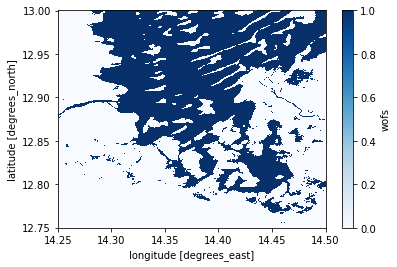

In [10]:
pre_water.wofs.plot(cmap = "Blues")

### Post-Rain Water Classifications

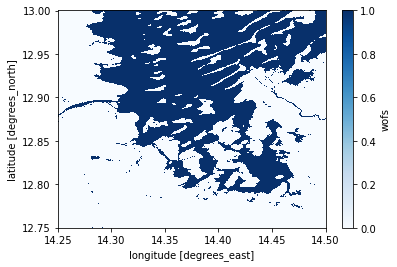

In [11]:
post_water.wofs.plot(cmap = "Blues")  

<br>  
<br>  
# Differencing Water products to reveal Water change  

The two images rendered above aren't too revealing when it comes to observing significant trends in water change. Perhaps we should take advantage of Xarrays arithmetic capabilities to detect or highlight change in our water classes.  
  
<br>  
![](diagrams/rainy_demo/differencing.png)  
<br>

<br>  
Arithmetic operations like addition and subtraction can be applied to xarray datasets that share the same shape. For example, the following differencing operation ....  
  
<br>

In [12]:
water_change = post_water - pre_water

<br>  
... applies the difference operator to all values within the wofs data-array with extreme efficiency. If we were, to check unique values again...  
<br>  

In [13]:
np.unique(water_change.wofs)  

array([-1.,  0.,  1.])

<br>  
... then we should encounter three values. 1, 0, -1. These values can be interpreted as values indicating change in water. The table below should serve as an incredibly clear reference:  
<br>  

\begin{array}{|c|c|}
\hline post & pre & diff & interpretation \\\hline
        1  & 0 & 1-0 = +1 & water gain \\\hline
        0  & 1 & 0-1 = -1 & water loss \\\hline 
        1  & 1 & 1-1= 0 & no-change \\\hline
        0  & 0 & 0-0=0 & no-change \\\hline
        \end{array}  

<br>  

Understanding the intuition and logic behind this differencing, I think we're ready to take a look at a plot of water change over the area...    
<br>  
<br>  


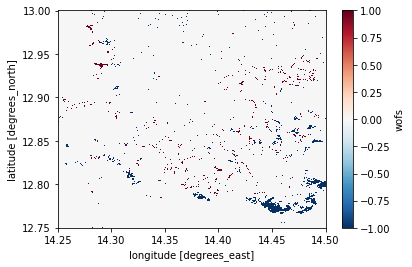

In [14]:
water_change.wofs.plot()

<br>  

### Interpreting the plot. Relying on non-visual results  

The plot above shows a surprisingly different story from our expectation of water growth. Large sections of lake chad seem to have dis-appeared after the rainy season. The recommended next step would be to explore change by methods of counting. 

In [15]:
## Create a boolean xarray
water_growth = (water_change.wofs ==  1)
water_loss   = (water_change.wofs == -1)

## Casting a 'boolean' to an 'int' makes 'True' values '1' and 'False' Values '0'. Summing should give us our totals 
total_growth = water_growth.astype(np.int8).sum()
total_loss   = water_loss.astype(np.int8).sum()

<br>  
The results...  
<br>  
  

In [16]:
print("Growth:",     int(total_growth.values))  
print("Loss:",       int(total_loss.values))
print("Net Change:", int(total_growth - total_loss))

Growth: 7344
Loss: 14170
Net Change: -6826


<br>  
### How to interpret these results  
Several guesses can be made here as to why water was lost after the rainy season. Since that is out scope for this lecture(and beyond the breadth of this developer's knowledge) I'll leave definitive answers to the right researchers in this field.  
  
What can be provided, however, is an addititional figure regarding trends precipitation.  
  
  
<br>
### Bringing back more GPM Data

Lets bring back the GPM data one more time and increase the time range by one year in both directions.  

Instead of spanning the year of **2015** to **2016**,  let's do **2014** to **2017**.   

> **Load GPM**  
> Using the same code from our first [gpm tutorial](igarrs_chad_01.ipynb), let's load in three years of rainfall data:  
<br>  


In [17]:
import datacube
dc = datacube.Datacube(app = "chad_rainfall", config = '/home/localuser/.datacube.conf') 

## Define Geographic boundaries using a (min,max) tuple.
latitude = (12.75, 13.0)
longitude = (14.25, 14.5)

## Specify a date range using a (min,max) tuple  
from datetime import datetime
time = (datetime(2014,1,1), datetime(2017,1,2))

## define the name you gave your data while it was being "ingested", as well as the platform it was captured on. 
product = 'gpm_imerg_gis_daily_global'
platform = 'GPM'  

measurements = ['total_precipitation']
gpm_data = dc.load(latitude = latitude, longitude = longitude, 
                   product = product, platform = platform, 
                   measurements=measurements)

<br>  
>** Display Data **   
>We'll aggregate spatial axis so that we're left with a mean value of the region for each point in time. Let's plot those points in a time series.  
<br>  

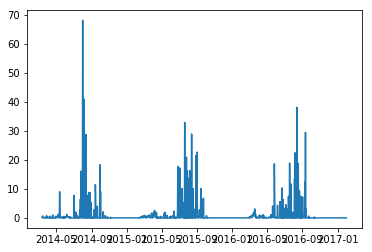

In [18]:
times = gpm_data.time.values
values = gpm_data.mean(['latitude', 'longitude']).total_precipitation.values

import matplotlib.pyplot as plt
plt.plot(times, values) 

# Next Steps  

This concludes our series on observing the rainy season's contributions to Lake Chad's surface area. Hopefully you've taken an understanding of, or even interest to datacube and xarrays.  
  
I encourage you to check out more of our notebooks on [our github](https://github.com/ceos-seo/data_cube_notebooks) with applications ranging from [landslide detection](https://github.com/ceos-seo/data_cube_notebooks/blob/master/slip.ipynb) to [fractional coverage](https://github.com/ceos-seo/data_cube_notebooks/blob/master/fractional_coverage.ipynb) or even the [Wofs water detection algorithm](https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb)  